##### This notebook shows how the `funcs.py` module can be used to analyse the results of the parameter fitting to an example trajectory of a perfect $\frac{a_0}{2}\langle 110 \rangle\{111\}$ dislocation using DE-MC. The DE-MC ouput can be found in the directory `de_mc_out`, which has been generated using the script `mc3_de_mc.py`.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from funcs import *

#### Loading dislocation trajectory

In [2]:
# Read in dislocation trajectory
# set path to file containing trajectory
filename = "./combined_data.txt"
n = 8      # number of trajectories included in analysis

# Non-dimensionalise the dislocation position data
t_dim, t_nondim, x_mean_dim, x_mean_nondim, x_std_dim, x_std_nondim, ts, xs = get_nondim_data(filename, n)

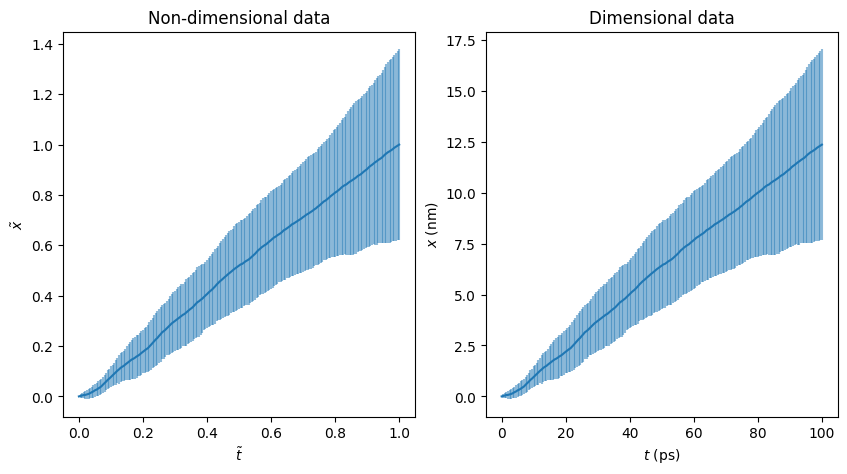

In [3]:
# Plot dislocation trajectory as a check
fig, axs = plt.subplots(1,2, figsize=(10,5))
# Non-dimensional data
axs[0].set_title("Non-dimensional data")
markers, caps, bars = axs[0].errorbar(t_nondim, x_mean_nondim, 2.0*x_std_nondim)
[bar.set_alpha(0.5) for bar in bars]
axs[0].set_xlabel(r"$\tilde{t}$")
axs[0].set_ylabel(r"$\tilde{x}$")
# Dimensional data
axs[1].set_title("Dimensional data")
markers, caps, bars = axs[1].errorbar(t_dim, x_mean_dim, 2.0*x_std_dim)
[bar.set_alpha(0.5) for bar in bars]
axs[1].set_xlabel(r"$t$ (ps)")
axs[1].set_ylabel(r"$x$ (nm)")

plt.show()

#### DE-MC Analysis

##### Extracting parameter distributions
Note that for the implementation of the equation of motion used here, the non-dimensional parameters $c_0$ and $c_1$ are lognormally distributed. Accordingly, some of the analysis shown is for $\ln c_0$ and $\ln c_1$, which are normally distributed, for convenience.
$$c_i = e^{\theta_i} ~ \text{Lognormal}$$
$$\ln c_i = \theta_i ~ \text{Normal}$$
where $\theta
_i$ is an accepted sample.

In [11]:
n_samples = int(1e5)                    # Number of DE-MC generations
burn = int(1e4)                         # Number of burn-in samples
dims = 2                                # Number of parameters
params = [r"$\ln c_0$", r"$\ln c_1$"]   # Parameter names

# load DE-MC output
data = np.load("./de_mc_out/de_mcmc.npz")

# Store all accepted samples
all_samples = data["posterior"].T

# Get parameter distributions and statistics after discarding burn-in samples
log_c_dist, log_c_mean, post_cov, log_c_std = get_posterior(data, n_samples, burn, dims)

# Summarise parameter statistics
df = pd.DataFrame({"parameter": params, "mean":log_c_mean, "std. dev":log_c_std})
df

,parameter,mean,std. dev
0,$\ln c_0$,3.470169,0.159315
1,$\ln c_1$,3.542563,0.147596


In [5]:
# Set the joint posterior distribution mean vector and covariance matrix
mu = np.array([round(m,3) for m in log_c_mean])
sigma = np.array([[round(post_cov[i][j],3) for i in range(dims)] for j in range(dims)])

##### Checking convergence: Trace Plots
Trace plots can be used to check that we have well-mixed Markov chains, which gives an indication of the convergence of the sampling process (or lack of). Examining the trace plots can also give a good indication of the appropriate number of burn-in samples, which are discarded from any subsequent analysis.  

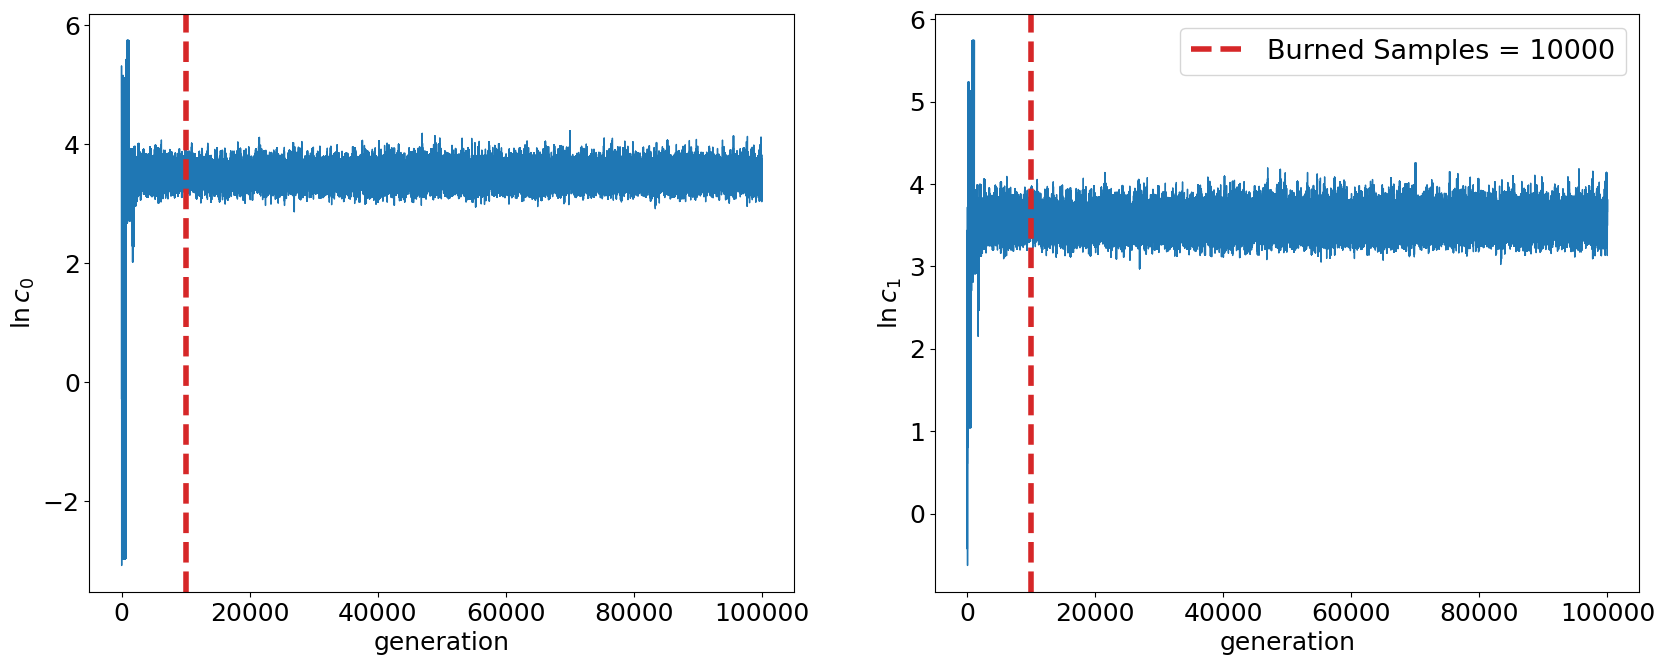

In [6]:
# Generate trace plot
plot_trace(dims,burn,all_samples,params,save_plt=False,show_plt=True)

##### Checking convergence: Parameter mean and standard deviation with increasing DE-MC generations
This is done as a further check to test the convergence of the DE-MC sampling. For a small number of DE-MC generations, this function is reasonably quick to run. However, for large numbers of DE-MC iterations, this becomes very slow and it is advisable to set `write_out = True`, which will <em>write out</em> the result of the calculation to a text file and this function can be run once per new analysis.

In [7]:
# Calculate parameter mean and standard deviation as a function of the number of DE-MC generations carried out
mean_conv, std_devs = stat_convergence(log_c_dist, dims, write_out=False)

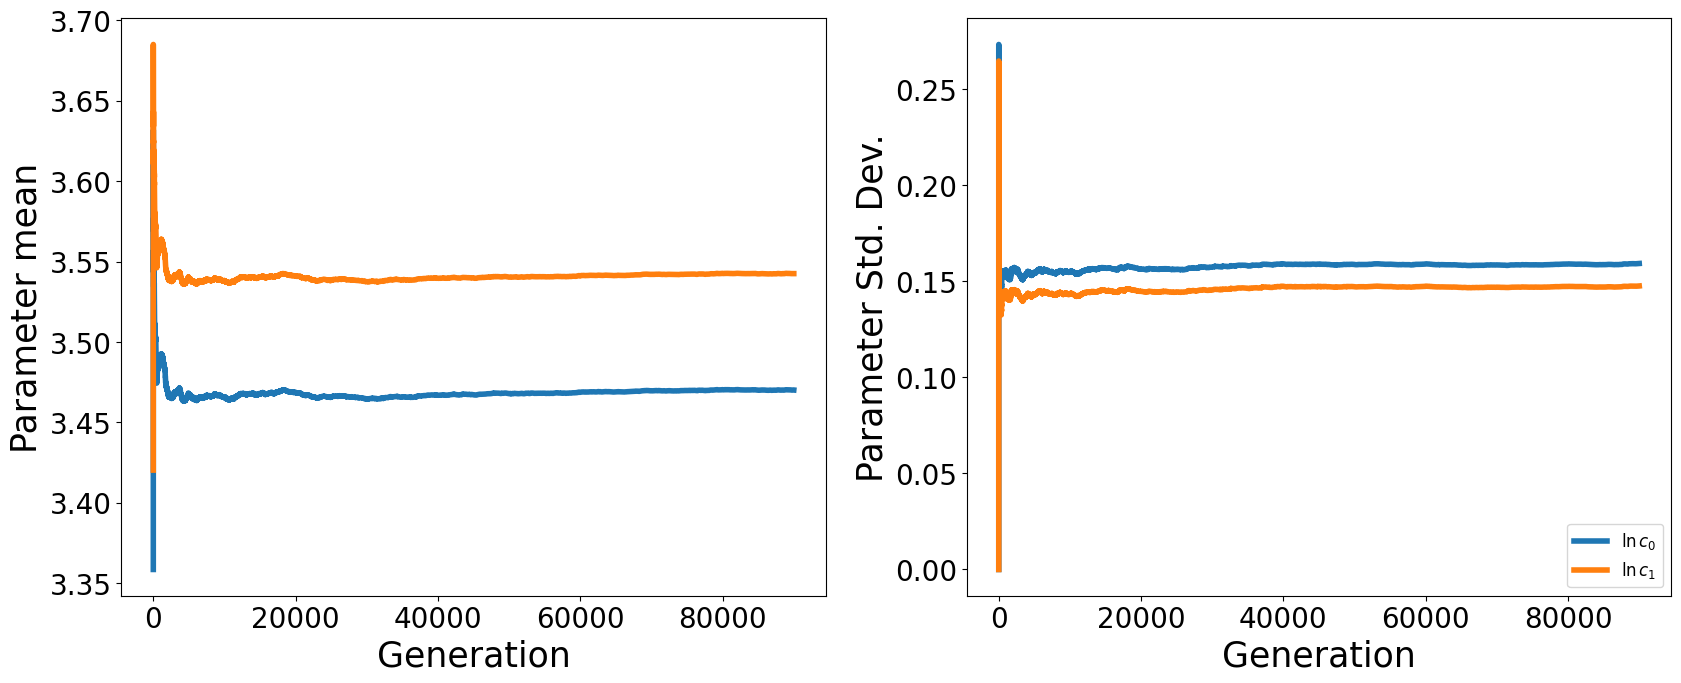

In [8]:
# Plot
plot_convg(dims,mean_conv,std_devs,params,save_plt=False,show_plt=True)

##### Plotting parameter distributions
In this case the joint posterior distribution over $\ln c_0$ and $\ln c_1$ is a bi-variate Normal distribution. To visualise the posterior distribution, we plot the marginal parameter distributions as well as a pairplot, which illustrates the parameter correlations. 

##### Marginal parameter distributions
Here we plot a histogram of the accepted samples of each parameter together with the distributions:
$$\ln c_0 \sim \mathcal{N}(3.47,0.025^2)$$
$$\ln c_1 \sim \mathcal{N}(3.543, 0.022^2)$$
Where the mean and variance of each parameter were previously estimated from the accepted samples. We can also optionally plot the prior distribution used for each parameter.

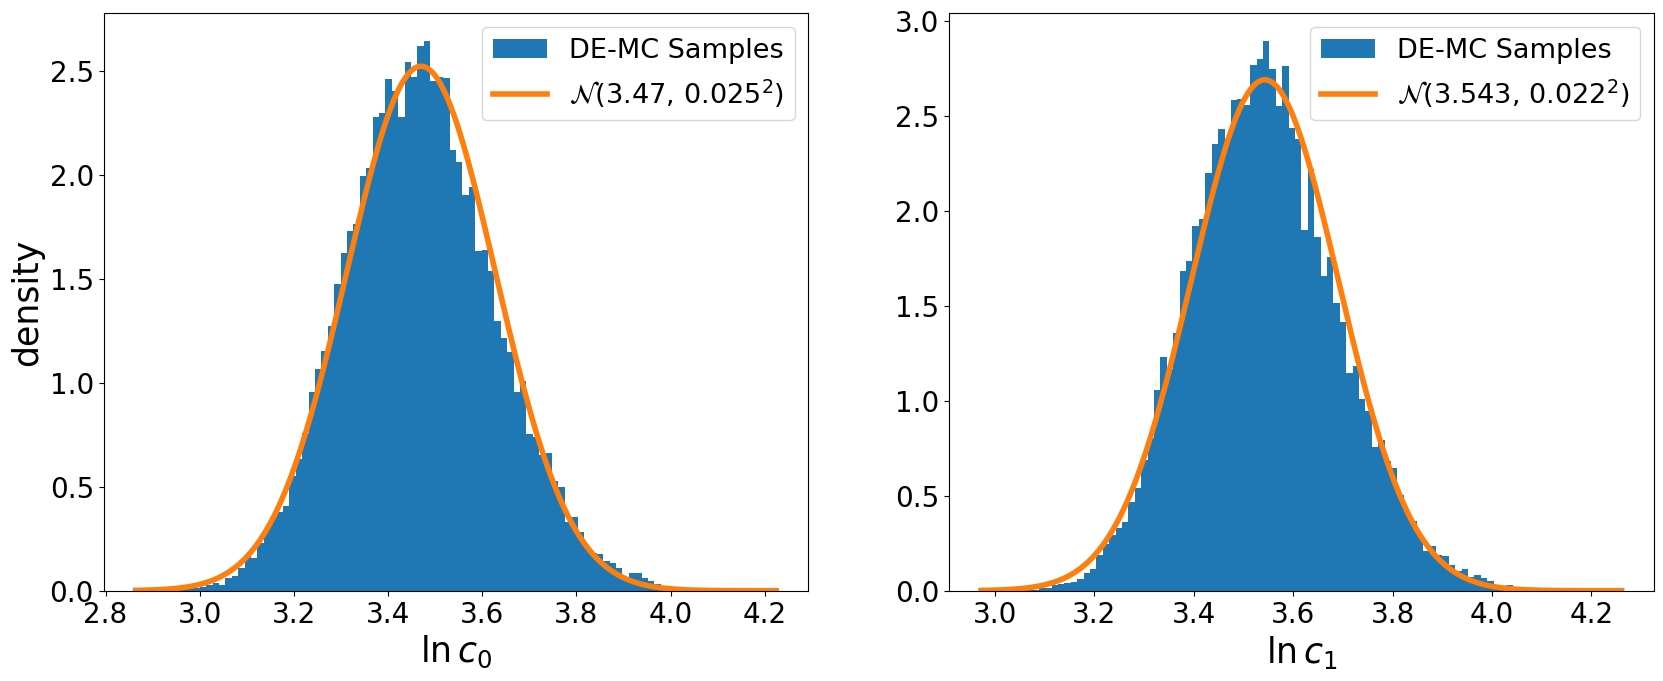

In [12]:
prior_dist = np.array([[0.0, 2.0],[0.0, 2.0]])    # prior mean and standard deviation
plot_marginal(dims,log_c_dist,mu,sigma,prior_dist,params,prior=False,save_plt=False,show_plt=True)

##### Parameter pairplot

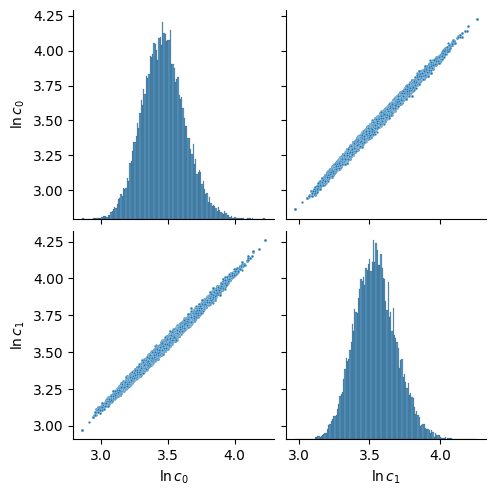

In [13]:
# Pairplot
plot_pairplot(log_c_dist, params, save_plt=True)

#### Mean model fit to data
Given the estimated parameter distributions calculated in the previous section, we can evaluate our model at the mean parameter values to obtain a <em>mean fit</em>. We can also generate samples from the joint posterior distribution, which will give us an idea of the uncertainty in our model predictions: the dislocation positions and velocities.

**Note**: We have been working with logs of the non-dimensional parameters $\ln c_0$ and $\ln c_1$ so we need to exponentiate and re-dimensionalise any values we sample from the parameter distributions prior to using them to evaluate the model.

In [14]:
# Mean parameters
c_mean = np.exp(mu)
mean_params = [c0_B_m(c_mean[0],ts), c1_F_m(c_mean[1],xs,ts)]

# Evaluate model at mean values
x0 = [0.0,0.0]

x_fit, v_fit = ODE_solution_dim(mean_params, x0, t_dim)

# Numerically differentiate the MD position data to get velocities 
v_dim = np.gradient(x_mean_dim, 500*0.001)

In [ ]:
# Applied stress and burgers vector
sigma_xz = 10.0                        # MPa
b = 0.352*np.sqrt(2)/2.0

# Get terminal velocity v_t from mean fit
v_t = v_fit[-1]                        # nm/ps
print(f"v_t = {v_t}")

# Calculate B, m, and F from mean values of fitted parameters
# B = sigma*b/v_t
B = sigma_xz*b/v_t
# m = B/c0
m = B/mean_params[0]
# F = m*c1
F = m*mean_params[1]
# Convert F from pN/nm to MPa
F_MPa = (F*(1e-12)*2*(1e18))/((1e6)*np.sqrt(2)*0.352)

# Calculate RMSE
rmse = np.sqrt((np.sum((x_fit - x_mean_dim)**2))/len(x_mean_dim))

# Summarise parameter statistics
df = pd.DataFrame({r"$v_t (\frac{\textrm{nm}}{\textrm{ps}})$": [round(v_t,2)] ,  r"$B$ ($\frac{\textrm{pN ps}}{\textrm{nm}^2}$)": [round(B,2)], r"$m (\frac{\textrm{pN ps}^2}{\textrm{nm}^2})$":[round(m,2)], r"$F$ (MPa)":[round(F_MPa,2)], "RMSE": [round(rmse,3)]})
df

v_t = 0.13297496420594312


,$v_t (nm/ps)$,B ($\frac{pN ps}{nm^2}$),$m (\frac{pN ps^2}{nm^2})$,$F$ (MPa),RMSE
0,0.13,18.72,58.24,10.0,0.2


In [22]:
# Draw samples from posterior
N = 500     # Number of samples

samples = st.multivariate_normal.rvs(mean=mu, cov=sigma, size=N)
samples_dim = [[c0_B_m(s[0],ts), c1_F_m(s[1],xs,ts)] for s in np.exp(samples)]

pos_model = np.array([ODE_solution_dim(s,x0,t_dim)[0] for s in samples_dim])
vel_model = np.array([ODE_solution_dim(s,x0,t_dim)[1] for s in samples_dim])

# Calculate uncertainties
# Means
pos_dim_mean = np.array([pos_model[:,i].mean() for i in range(len(t_dim))])
vel_dim_mean = np.array([vel_model[:,i].mean() for i in range(len(t_dim))])
# 2*sigma
pos_dim_error = np.array([2.0*pos_model[:,i].std() for i in range(len(t_dim))])
vel_dim_error = np.array([2.0*vel_model[:,i].std() for i in range(len(t_dim))])

pos_upper = pos_dim_mean+pos_dim_error
pos_lower = pos_dim_mean-pos_dim_error

vel_upper = vel_dim_mean+vel_dim_error
vel_lower = vel_dim_mean-vel_dim_error

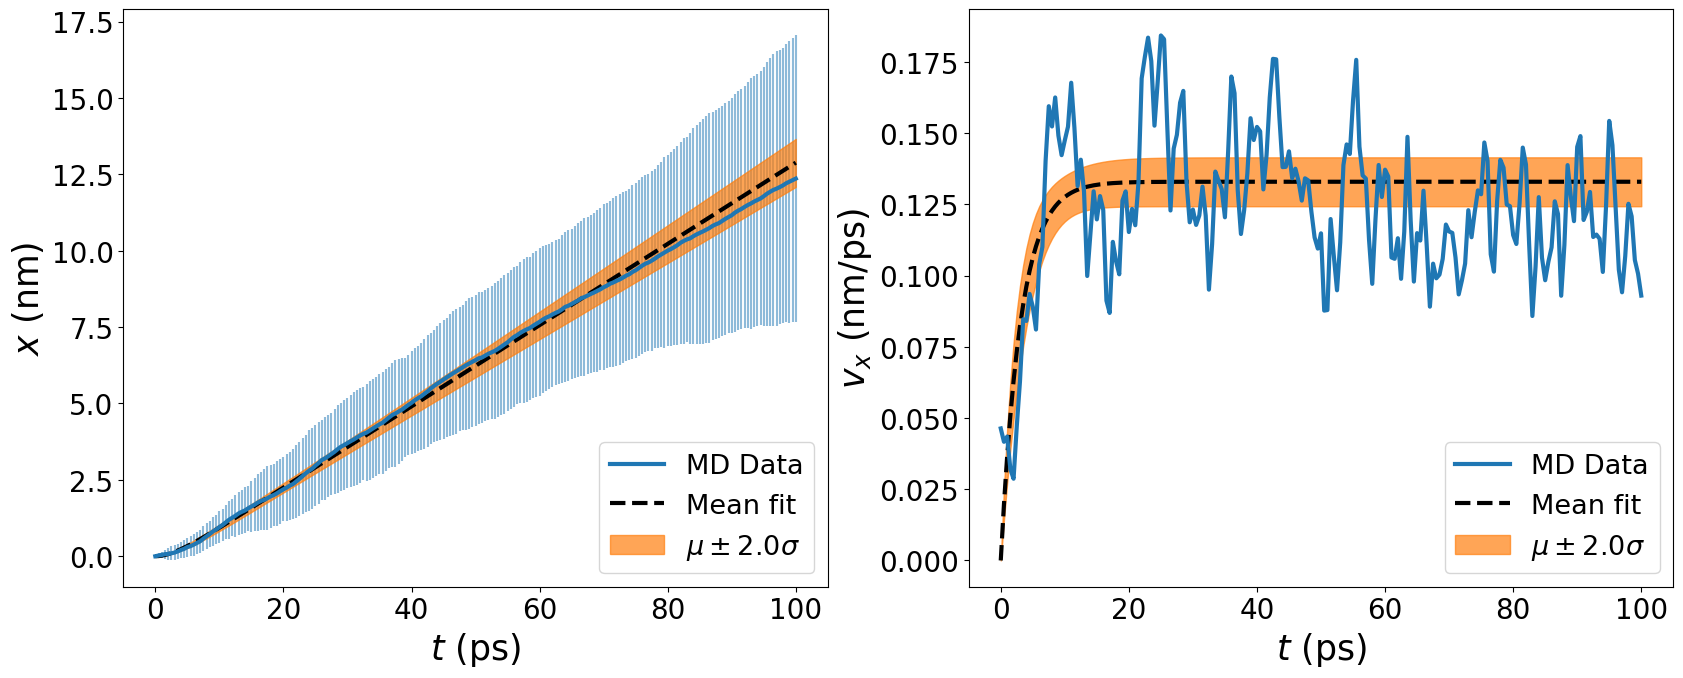

In [33]:
# Plot fit
fig, axs = plt.subplots(1,2, figsize=(20,7.5))

# MD Data
markers, caps, bars = axs[0].errorbar(t_dim, x_mean_dim, 2.0*x_std_dim, zorder=1)
[bar.set_alpha(0.5) for bar in bars]
axs[0].plot(t_dim, x_mean_dim, color="C0", label="MD Data", lw=3, zorder=4)      # position
axs[1].plot(t_dim, v_dim, color="C0", label="MD Data", lw=3, zorder=4)           # velocity

# Mean fits
axs[0].plot(t_dim, x_fit, color="k", ls="--", lw=3, zorder=3, label = "Mean fit")   # position
axs[1].plot(t_dim, v_fit, color="k", ls="--", lw=3, zorder=3, label = "Mean fit")   # velocity

# Uncertainty
axs[0].fill_between(t_dim, pos_lower, pos_upper, color="C1", alpha=0.7, zorder=1, label=r"$\mu \pm 2.0\sigma$")
axs[1].fill_between(t_dim, vel_lower, vel_upper, color="C1", alpha=0.7, zorder=1, label=r"$\mu \pm 2.0\sigma$")

for ax in axs:
    ax.set_xlabel(r"$t$ (ps)", fontsize=25)
    ax.tick_params(axis='both', labelsize=20)
    ax.legend(loc="lower right", fontsize=19.5)

axs[0].set_ylabel(r"$x$ (nm)", fontsize=25)
axs[1].set_ylabel(r"$v_x$ (nm/ps)", fontsize=25)

fig.savefig("fit.png", format="png", dpi=350, bbox_inches="tight")
plt.show()